# Note for Maya\Yair\Eran:
This notebook is for the final submission, and will contain the entire project flow.
In order to update this document please submit a Purll Request from your branch to the master branch, with the other team mates as reviewers.

Until then, please develop in a separate notebook, with the name '{your_name}_in_progress.ipynb'.
Updates to '...in_progress' notebook should not be pushed to master.

# House Prices - Regression Predictions YData 2024
Team: TODO

Team mates: Eran T, Maya L, Yair BH

TODO: add table of content with links

## Part 1 - EDA

In [1]:
from utils import load_house_prices_data
import matplotlib.pyplot as plt 

train_df = load_house_prices_data('train')
train_features = train_df.drop('SalePrice', axis='columns')

### 1.1 Which 3 features have the highest number of missing values?

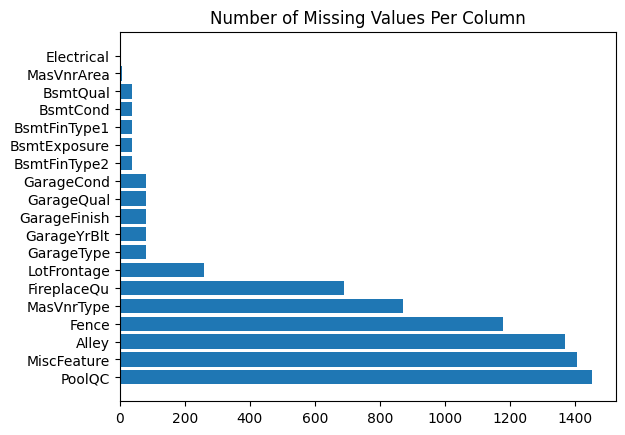

Top 3 features with the most missing values: ['PoolQC' 'MiscFeature' 'Alley']


In [2]:
from utils import calc_num_missing_vals_per_col, np

num_of_nans = calc_num_missing_vals_per_col(train_features)

fig, ax = plt.subplots()
y_pos = np.arange(len(num_of_nans))
ax.barh(y_pos, num_of_nans.values, align='center')
ax.set_yticks(y_pos, labels=num_of_nans.index)
ax.set_title('Number of Missing Values Per Column')
plt.show()

max_nans = num_of_nans.nlargest(3).index
print(f"Top 3 features with the most missing values: {max_nans.values}")

### 1.2 How does the price behave over the years?

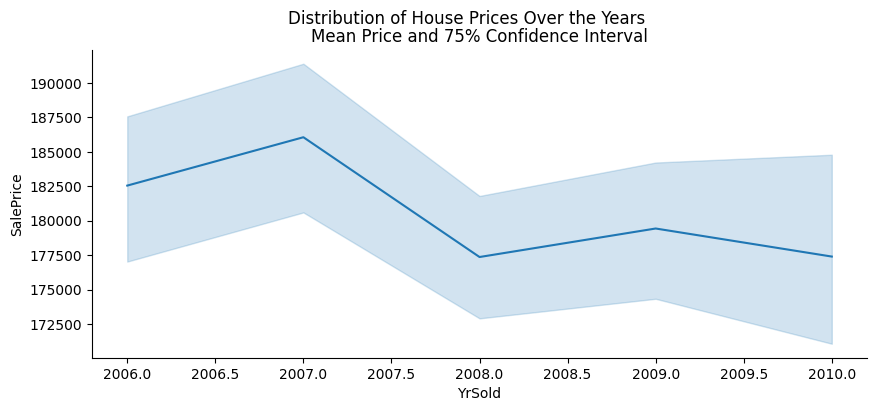

In [3]:
from utils import plot_price_dist_per_year

plot_price_dist_per_year(train_df)

### 1.3 Plotting feature distribution using histograms

In [4]:
# todo

### 1.4 Computing Feature Correlation and Ordering by the Correlation

In [5]:
# todo

### 1.5 More EDA that will help us understand the data and support our modelling decisions

In [6]:
# todo - what will be out modeling decision?
# todo - what graphs will support this?

## Part 2 - Baseline Model

In [7]:
# todo train the simplest baseline model possible
# todo share baseline model results
# todo submit your baseline results to kaggle website